In [ ]:
import pandas as pd

# Load the provided stock price data to understand its structure
file_path = '/mnt/data/stock_price.csv'
stock_data = pd.read_csv(file_path)

# Display the first few rows and basic info about the data
stock_data.head(), stock_data.info()


The dataset contains 9,202 entries with 7 columns:

日付け (Date): Object type (dates in YYYY-MM-DD format).
終値 (Closing price): Float (the stock's closing price for the day).
始値 (Opening price): Float (the stock's opening price for the day).
高値 (High price): Float (the stock's highest price for the day).
安値 (Low price): Float (the stock's lowest price for the day).
出来高 (Volume): Object type (contains stock volume with 'M' suffix for millions).
**変化率 % (Change rate %) **: Object type (percentage change in stock price).
Next, I will clean and preprocess this data, starting with date parsing, conversion of numerical columns, and handling missing or incorrect values





In [ ]:
def convert_volume(value):
    if 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    else:
        return float(value)

try:
    stock_data['出来高'] = stock_data['出来高'].apply(convert_volume)

    # Remove '%' from '変化率 %' and convert to float
    stock_data['変化率 %'] = stock_data['変化率 %'].str.replace('%', '').astype(float)

    # Check for any missing or invalid data after conversion
    stock_data.isnull().sum(), stock_data.head()

    # Change columns into English Reference
    stock_data.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change %']

    # Convert 'Date' column to datetime format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Set 'Date' as the index for time series analysis
    stock_data.set_index('Date', inplace=True)

    # Summary statistics of the dataset to check for any anomalies
    summary_stats = stock_data.describe()

    # Display the summary statistics
    summary_stats
except Exception as e:
    print(f"An unexpected error occurred during the transformation: {e}")

stock_data.to_csv('Updated_Data.csv', index=False)


The summary statistics for the dataset are now clean. Here are some key observations:

Closing Prices: The mean closing price is around 92.18 with a maximum of 305.90.
Trading Volume: The average volume is approximately 172.67 million shares, with the maximum volume being around 1.28 billion shares.
Change %: The stock price change ranges from -14.74% to 16.25%, with a mean of about 0.0175%.

The data has been successfully cleaned:

The Volume (出来高) column now has consistent numerical values in both millions and billions.
The Change Rate (変化率 %) column is now converted to numeric format (as a float without the percentage symbol).
There are no missing values in the dataset.

Next, I'll proceed with exploratory data analysis (EDA) to visualize stock price trends, volume fluctuations, and any seasonal patterns.

In [ ]:
# Load the provided stock price data to understand its structure
file_path = 'Updated_Data.csv'   # Updated and cleaned data file
Updated_Data = pd.read_csv(file_path)

# Plotting data to visualize trends and distributions
plt.figure(figsize=(14, 8))

# Subplot 1: Closing Price Over Time
plt.subplot(2, 2, 1)
plt.plot(Updated_Data['Close'], color='blue', label='Close Price')
plt.title('Closing Price Over Time')
plt.ylabel('Price')
plt.xlabel('Time')

# Subplot 2: Stock Price Distribution (Close)
plt.subplot(2, 2, 2)
sns.histplot(Updated_Data['Close'], kde=True, color='green')
plt.title('Distribution of Closing Prices')

# Subplot 3: Volume Over Time
plt.subplot(2, 2, 3)
plt.plot(Updated_Data['Volume'], color='red', label='Volume')
plt.title('Trading Volume Over Time')
plt.ylabel('Volume')
plt.xlabel('Time')

# Subplot 4: Change % Distribution
plt.subplot(2, 2, 4)
sns.histplot(Updated_Data['Change %'], kde=True, color='purple')
plt.title('Distribution of Percentage Change')

plt.tight_layout()
plt.show()

summary_stats

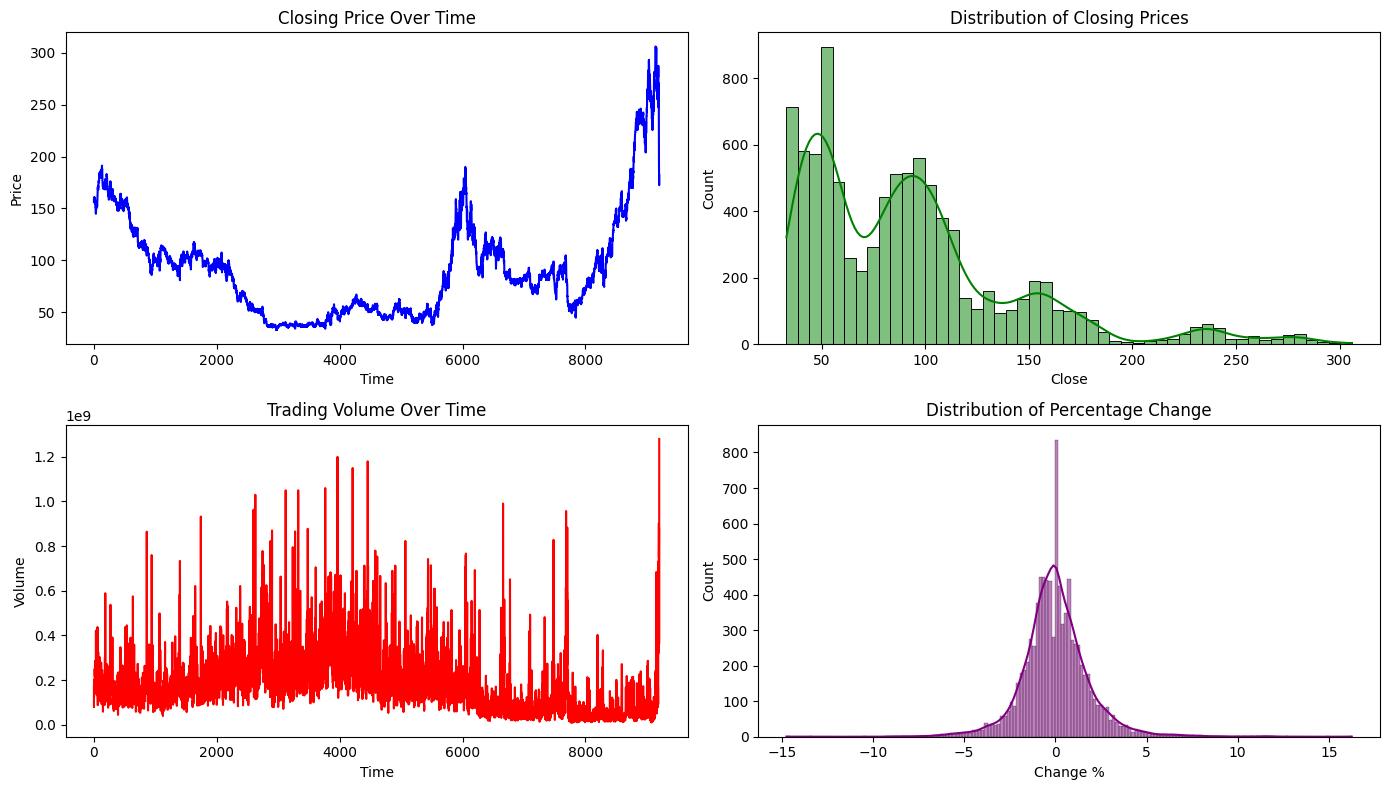

# LSTM - Long Short Term Memory Model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Load the provided stock price data
file_path = 'Updated_Data.csv'
data = pd.read_csv(file_path)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Separating features (X) and target variable (y) - predicting 'Close' price
X_train = train_data.drop(columns=['Close']).values
y_train = train_data['Close'].values
X_test = test_data.drop(columns=['Close']).values
y_test = test_data['Close'].values

# Reshape the input to be [samples, time steps, features] as required by LSTM
# Here we assume a time step of 1 because your data is structured for each row as one time step
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()

# Adding the first LSTM layer and Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))

# Adding a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer (since we are predicting a single value, the Close price)
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Model Loss: {loss}')

# Make predictions
predictions = model.predict(X_test_reshaped)

# Print the loss and predictions for further analysis
print(predictions)


# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

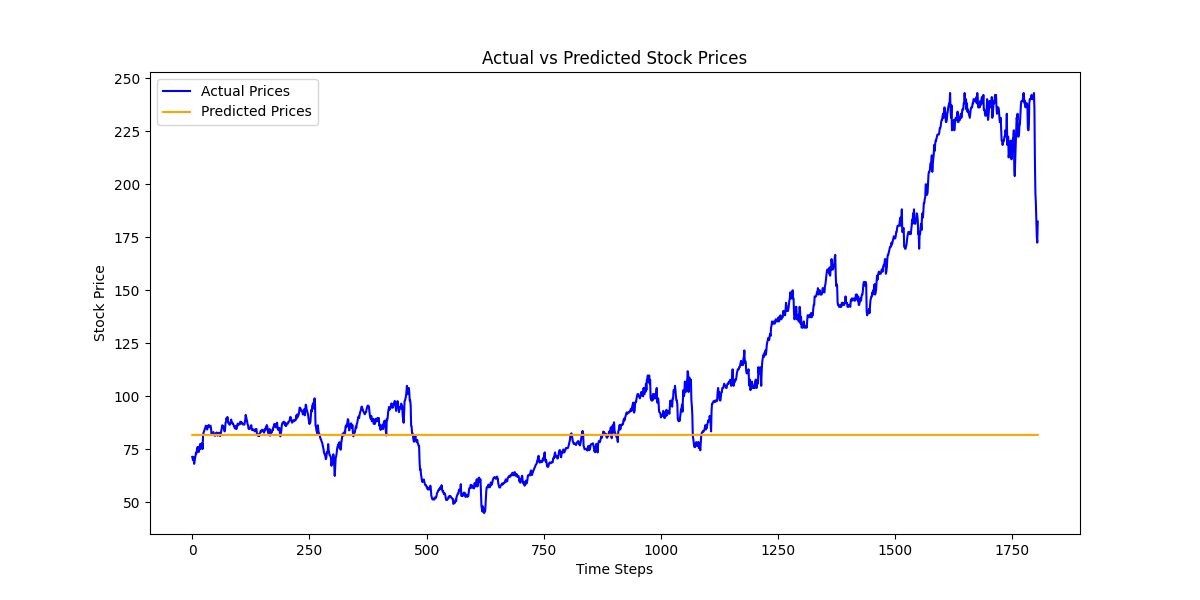

This plot compares the actual stock prices to the predicted prices generated by the LSTM model. As depictede the predicted prices are poorly following the actual prices and model is underfitting

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the provided stock price data
file_path = 'Updated_Data.csv'
data = pd.read_csv(file_path)

# Remove outliers using Z-score
data = data[(np.abs(stats.zscore(data['Close'])) < 3)]

# Feature scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale only the feature columns (excluding 'Close')
scaled_X = scaler_X.fit_transform(data.drop(columns=['Close']))
scaled_y = scaler_y.fit_transform(data[['Close']])

# Combine the scaled features and target
scaled_data = np.concatenate([scaled_X, scaled_y], axis=1)

# Splitting the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences of data for LSTM
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :-1])  # All features except 'Close'
        y.append(data[i, -1])  # 'Close' is the last column
    return np.array(X), np.array(y)

sequence_length = 60  # You can experiment with this value
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape input to be [samples, time steps, features]
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Build the LSTM model
model = Sequential()

# Adding the first LSTM layer and Dropout
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

# Adding a second LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))

# Adding a third LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling to get original price values for the 'Close' price
predictions_scaled_back = scaler_y.inverse_transform(predictions)
y_test_scaled_back = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled_back, label='Actual Prices', color='blue')
plt.plot(predictions_scaled_back, label='Predicted Prices', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


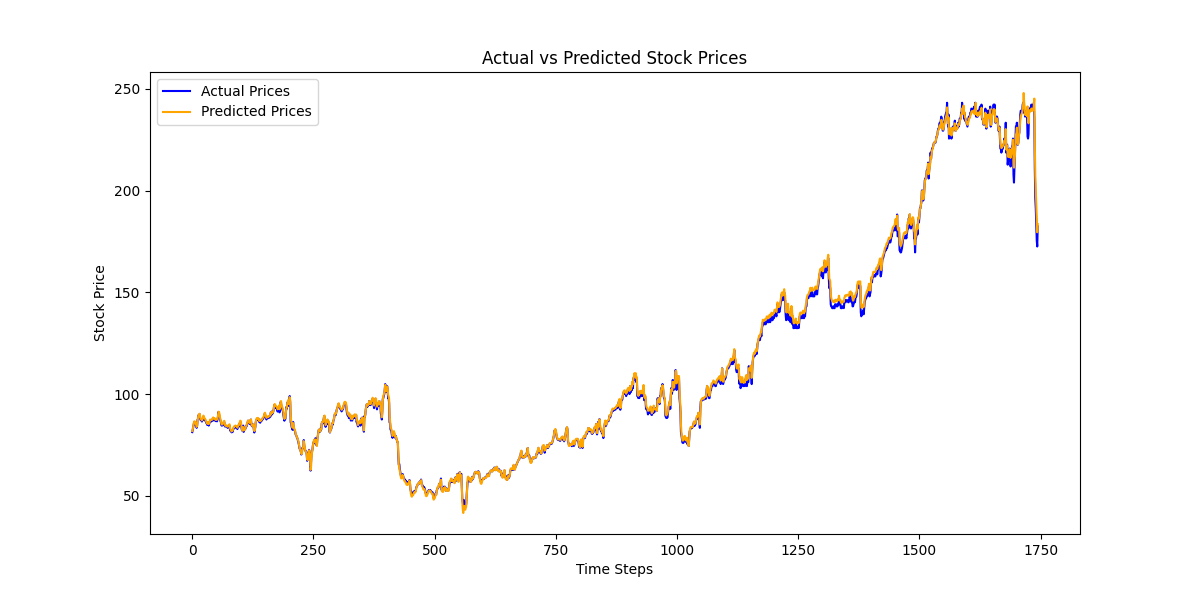

IMPROVEMENTS:

Data Scaling: The MinMaxScaler is applied to both input features and the target Close price to normalize the data within the range [0, 1]. This helps LSTM models converge faster and perform better.

Multiple Time Steps: Instead of assuming each row represents one time step, we used a sliding window approach where the model looks at the past 60 time steps to predict the next Close price.

More LSTM Layers: We increased the number of LSTM units to capture more complex temporal patterns. Three LSTM layers are used, each followed by a dropout layer to prevent overfitting.

Early Stopping: Added early stopping to avoid overfitting by stopping the training if the validation loss doesn’t improve for 5 consecutive epochs.

Predictions and Inverse Scaling: After making predictions, we scale the predictions back to the original price range using the inverse transformation of the MinMaxScaler.

Split the Scaler: Instead of scaling the entire data at once, you can scale the Close price separately to apply the inverse transformation correctly.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the provided stock price data
file_path = 'Updated_Data.csv'
data = pd.read_csv(file_path)

# Remove outliers using Z-score
data = data[(np.abs(stats.zscore(data['Close'])) < 3)]

# Feature scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Scale only the feature columns (excluding 'Close')
scaled_X = scaler_X.fit_transform(data.drop(columns=['Close']))
scaled_y = scaler_y.fit_transform(data[['Close']])

# Combine the scaled features and target
scaled_data = np.concatenate([scaled_X, scaled_y], axis=1)

# Splitting the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences of data for LSTM
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :-1])  # All features except 'Close'
        y.append(data[i, -1])  # 'Close' is the last column
    return np.array(X), np.array(y)

sequence_length = 30  # Reduced sequence length to speed up training
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape input to be [samples, time steps, features]
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Build the LSTM model
model = Sequential()

# Adding the first LSTM layer and Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Adding a second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling to get original price values for the 'Close' price
predictions_scaled_back = scaler_y.inverse_transform(predictions)
y_test_scaled_back = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled_back, label='Actual Prices', color='blue')
plt.plot(predictions_scaled_back, label='Predicted Prices', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


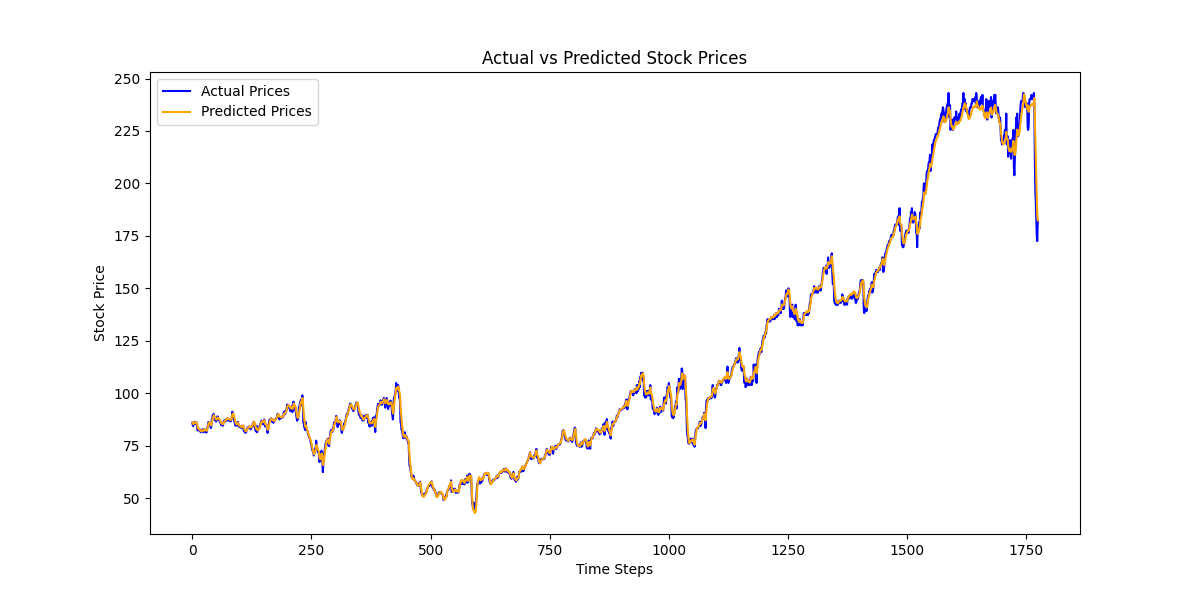


To Improve The Time per Epoch


Reduced Sequence Length: Set to 30 instead of 60. A smaller sequence length reduces computation but might still capture relevant trends.

Reduced LSTM Units: Reduced from 100 units per layer to 50. This cuts down the computation time while maintaining model performance.

Batch Size: Increased the batch size to 64. Larger batch sizes speed up training at the risk of slightly less frequent updates to model weights, but with proper tuning, this can significantly reduce epoch times.

Epochs: Reduced to 20 epochs, since early stopping is in place, it will stop when no further improvement is observed.

## Next Model : Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided stock price data to understand its structure
file_path = 'Updated_Data.csv'
df = pd.read_csv(file_path)

# Create lag features for Closing Price
df['Lag1'] = df['Close'].shift(1)


# Define features  and target Closing Price
X = df[['Lag1','Volume']]
Y = df[['Close']]

# Drop any rows with missing values after applying lag features
combined = pd.concat([X, Y], axis=1).dropna()

# Separate the features and target from the cleaned dataset
X = combined[['Lag1', 'Volume']]
Y = combined[['Close']]

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X, Y)

# Predict the stock Closeing prices using the trained model
pred = model.predict(X).ravel()

# Create a pandas series for predicted values
Y_pred = pd.Series(pred, index=X.index)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.scatter(X['Lag1'], Y, color='blue', label='Actual Price', alpha=0.5)
plt.plot(X['Lag1'], Y_pred, color='red', linewidth=2, label='Predicted Price')
plt.title('Actual vs Predicted Closing Price')
plt.xlabel('Features')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


To enhance the model's performance and predictive accuracy, we incorporated a lag feature for the 'Close' price, driven by our findings that lagged correlation between previous 'Close' prices and future values increased over time. By capturing the time-dependent relationships within the stock price data, lagged features allow us to account for the sequential patterns that directly influence future price predictions.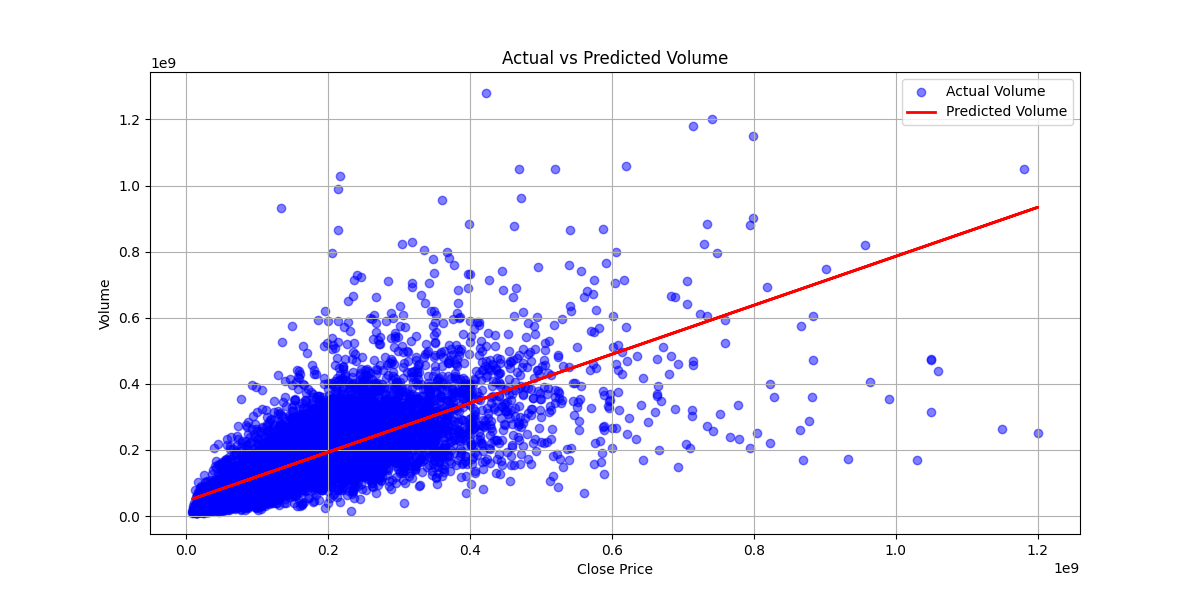

The dataset has no missing values, so we can proceed with splitting the data into training and testing sets. We'll use 80% of the data for training and 20% for testing.

I'll now prepare the features (Open, High, Low, Volume, and Lag1) and the target variable (Close), then split the data. ​​

The data has been successfully split into training and testing sets. The training set contains 7,361 samples, and the testing set contains 1,841 samples.

Final Result of Linear Regression Model ater combining all the Data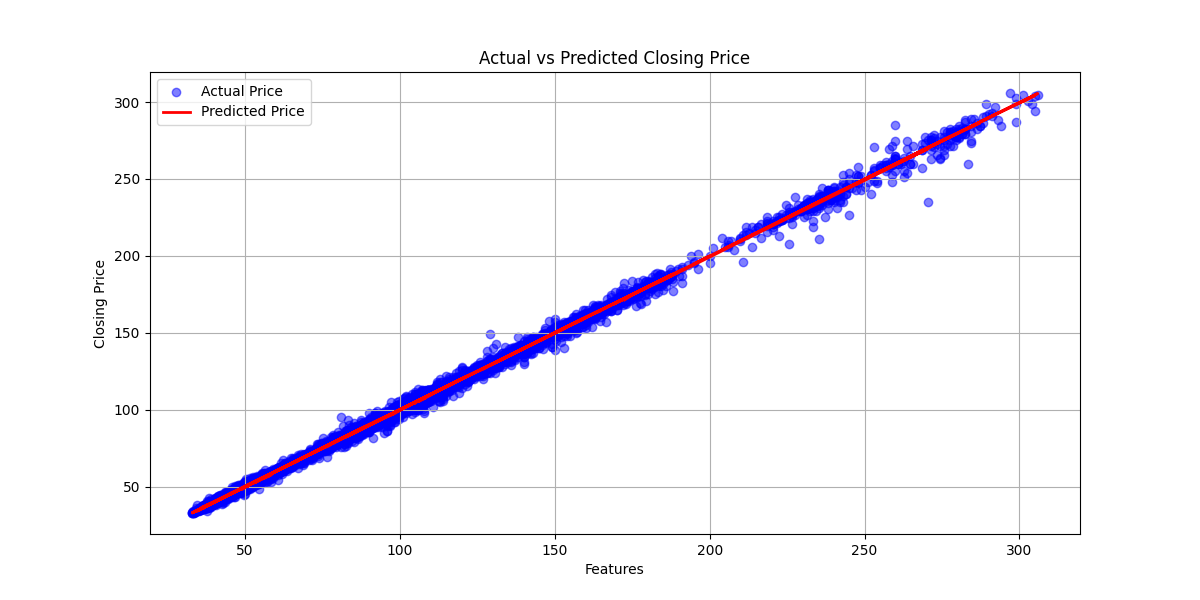

# ARIMA Model

In [ ]:
# Import necessary libraries for ARIMA modeling
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Load the provided stock price data
file_path = 'Updated_Data.csv'
data = pd.read_csv(file_path)

# Using only the 'Close' prices for ARIMA model
close_prices = data['Close']

# Detect and Remove Outliers using Z-score
z_scores = np.abs((close_prices - close_prices.mean()) / close_prices.std())
threshold = 3  # You can adjust the threshold as per your need
close_prices_clean = close_prices[z_scores < threshold]

# Visualize the original and cleaned data
plt.figure(figsize=(10, 6))
plt.plot(close_prices, label='Original Close Prices', alpha=0.5)
plt.plot(close_prices_clean, label='Cleaned Close Prices (Outliers Removed)', color='orange')
plt.title('Stock Prices Over Time (Before and After Outlier Removal)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

# Check for stationarity using the Augmented Dickey-Fuller (ADF) test on cleaned data
adf_test = adfuller(close_prices_clean)
print(f"ADF Statistic (Cleaned Data): {adf_test[0]}")
print(f"p-value (Cleaned Data): {adf_test[1]}")

# If the time series is non-stationary (p-value > 0.05), difference it
if adf_test[1] > 0.05:
    print("Time series is non-stationary. Applying differencing.")
    close_prices_clean = close_prices_clean.diff().dropna()  # First differencing

# Check stationarity again after differencing
adf_test = adfuller(close_prices_clean)
print(f"After Differencing - ADF Statistic: {adf_test[0]}")
print(f"After Differencing - p-value: {adf_test[1]}")

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(close_prices_clean, label='Differenced Close Prices (Outliers Removed)', color='orange')
plt.title('Differenced Close Prices (After Outlier Removal)')
plt.xlabel('Time')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.grid()
plt.show()

# Split data into training and test sets (80% training, 20% testing)
train_size = int(len(close_prices_clean) * 0.8)
train_data, test_data = close_prices_clean[:train_size], close_prices_clean[train_size:]

# Automatically select the best ARIMA parameters using auto_arima
auto_model = auto_arima(train_data, seasonal=True, m=12, stepwise=True, trace=True,
                        suppress_warnings=True, error_action="ignore", start_p=1, start_q=1, max_p=5, max_q=5)

# Get the best ARIMA order
order = auto_model.order
print(f'Optimal ARIMA order: {order}')

# Perform rolling forecast
history = list(train_data)
predictions = []

for t in range(len(test_data)):
    # Fit the ARIMA model to the current history
    model = ARIMA(history, order=order)
    model_fit = model.fit()

    # Forecast one step ahead
    forecast = model_fit.forecast(steps=1)
    predictions.append(forecast[0])

    # Update the history with the new value (use actual value from test_data)
    history.append(test_data.iloc[t])

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
print(f'Mean Squared Error (Rolling Forecast): {mse}')
print(f'Mean Absolute Error (Rolling Forecast): {mae}')

# Reset index for plotting
test_data = test_data.reset_index(drop=True)
predictions_index = range(len(predictions))  # Create a simple index for predictions

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Actual Close Prices', color='blue')
plt.plot(predictions_index, predictions, label='Predicted Close Prices', color='red')
plt.title('ARIMA Rolling Forecast - Actual vs Predicted Stock Prices (Outliers Removed)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()



Output optimal pair was (0,0,0) even after outliers removed so we'll move on to SARIMA for more detailed prediction for Seasonality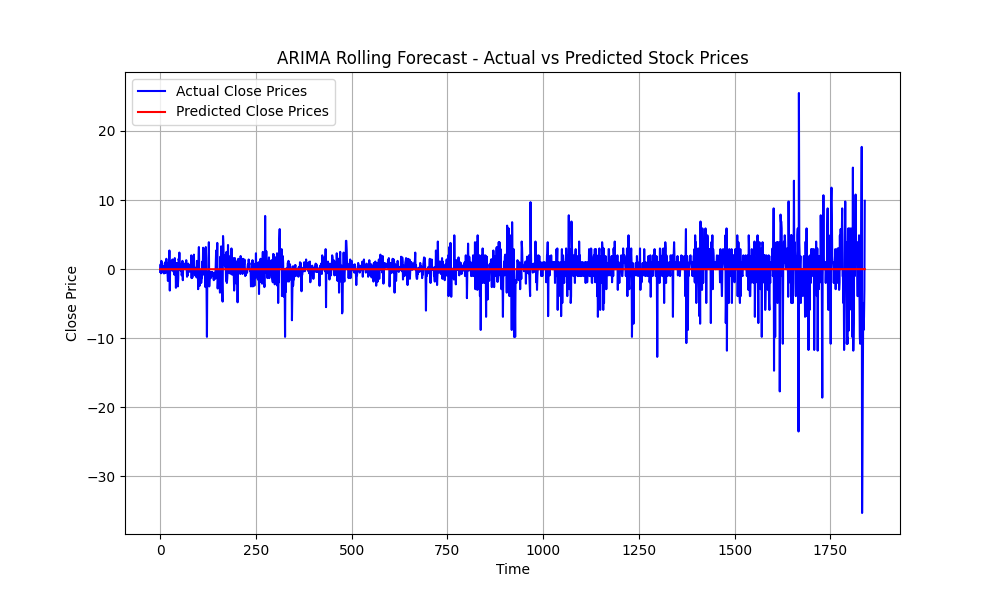

# PROPHET MODEL BY HUGGING FACE

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from prophet import Prophet
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from prophet.plot import plot_plotly
import plotly.offline as py

# Load the stock price data
file_path = 'Updated_Data.csv'
data = pd.read_csv(file_path)

# Generate a Date column assuming data is collected on consecutive business days
data_length = len(data)
start_date = '2020-01-01'  # Adjust this if you know the real start date
data['Date'] = pd.date_range(start=start_date, periods=data_length, freq=BDay())

# Remove outliers using Z-score
z_scores = np.abs(stats.zscore(data['Close']))
data = data[(z_scores < 3)]  # Remove extreme outliers

# Prepare the data for Prophet
prophet_data = data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize the Prophet model and add additional seasonality (weekly and monthly patterns)
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model.add_seasonality(name='monthly', period=26, fourier_order=7)  # Add monthly seasonality

# Fit the model
model.fit(prophet_data)

# Define future data points for prediction (365 business days ahead)
future = model.make_future_dataframe(periods=365, freq='B')

# Make predictions
forecast = model.predict(future)

# Plot the forecast using matplotlib
fig = model.plot(forecast)
plt.title("Prophet Model: Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()

# Plot forecast components (trend, yearly seasonality, weekly seasonality, etc.)
fig2 = model.plot_components(forecast)
plt.show()

# Plot the forecast using Plotly for an interactive plot
fig3 = plot_plotly(model, forecast)
py.plot(fig3)  # Interactive plot in the browser



Add More Seasonality Components in Prophet model



Removed the possible Outliers




Lack of Historical Data distorted the prices towards the end





# Final Graph for Prophet model

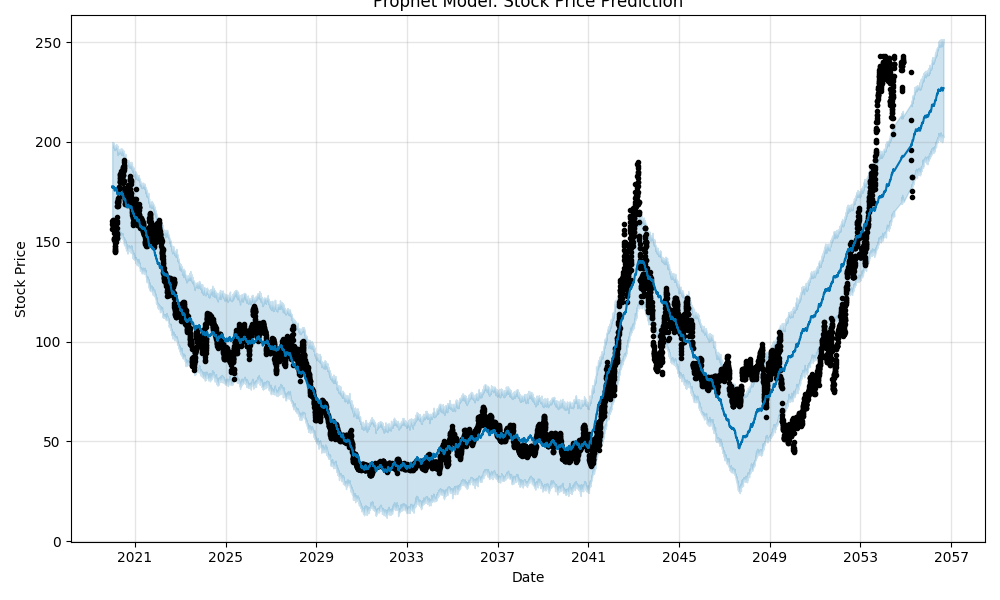

# Chronos Model

In [ ]:
!pip install bigdl-chronos
!pip install pandas matplotlib scikit-learn scipy
!pip install --pre bigdl-chronos[pytorch]

import pandas as pd
import numpy as np
from scipy import stats
from bigdl.chronos.data import TSDataset
import datetime


from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


# Load the provided stock price data
file_path = '/Updated_Data.csv'
df = pd.read_csv(file_path)

# Remove rows with missing/null values
df = df.dropna()

# Remove outliers using Z-score method (threshold set to 3)
z_scores = np.abs(stats.zscore(df['Close']))
df = df[z_scores < 3]

# Alternatively, we can use the IQR method (interquartile range) to remove outliers.
# Q1 = df['Close'].quantile(0.25)
# Q3 = df['Close'].quantile(0.75)
# IQR = Q3 - Q1
# df = df[(df['Close'] >= Q1 - 1.5 * IQR) & (df['Close'] <= Q3 + 1.5 * IQR)]


# Add the current date to all rows
df['Date'] = datetime.datetime.now().strftime("%Y-%m-%d")


# Ensure the 'Date' column is in the correct datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by date to ensure it is in chronological order
df = df.sort_values(by='Date')

# Select features and target for the model
features = ['High', 'Low', 'Open', 'Volume']  # Modify if needed
target = ['Close']

# Feature scaling (MinMaxScaler for Chronos compatibility)
scaler = MinMaxScaler()

# Normalize the features and target
df[features] = scaler.fit_transform(df[features])
df[target] = scaler.fit_transform(df[target])

# Prepare the time series data for Chronos
# TSDataset object requires (time, value, feature)
tsdata = TSDataset.from_pandas(df, dt_col='Date', target_col='Close',
                               feature_col=features,
                               extra_feature_col=None)

# Split the data into train and test sets
train_tsdata, test_tsdata = tsdata.split(0.8)

# Initialize and train the LSTMForecaster model from Chronos
lstm_forecaster = LSTMForecaster(past_seq_len=30,  # look-back period
                                 future_seq_len=1,  # predict 1 day ahead
                                 input_feature_num=len(features),
                                 output_feature_num=1,  # Predicting 'Close'
                                 lstm_hidden_dim=64,
                                 lstm_layer_num=2,
                                 dropout=0.2)

# Fit the model on the training data
lstm_forecaster.fit(train_tsdata, epochs=20, batch_size=32)

# Make predictions on the test set
y_pred = lstm_forecaster.predict(test_tsdata)

# Inverse transform the scaled predictions back to the original scale
y_pred_inverse = scaler.inverse_transform(y_pred)

# Evaluate the performance (you can use MSE, MAE, RMSE metrics)
mse = lstm_forecaster.evaluate(test_tsdata, metrics=['mse'])

print(f'Mean Squared Error on Test Data: {mse}')


# Convert test data and predictions to a DataFrame for easy plotting
test_dates = test_tsdata.to_pandas()['Date']

plt.figure(figsize=(12, 6))
plt.plot(test_dates, scaler.inverse_transform(test_tsdata.to_pandas()[['Close']]), label='Actual Close Price', color='blue')
plt.plot(test_dates, y_pred_inverse, label='Predicted Close Price', color='red', linestyle='--')
plt.title('Chronos Model: Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# Sarima Model - Seasonality included ,Outliers removed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Load your dataset
data = pd.read_csv('Updated_Data.csv')

# # Assuming the time series is stored in a column named 'Close' and 'Date' column exists
# data['Date'] = pd.to_datetime(data['Date'])
# data.set_index('Date', inplace=True)

# Visualize the time series data
plt.figure(figsize=(10,6))
plt.plot(data['Close'], label='Stock Price')
plt.title('Time Series Data')
plt.show()

# Step 1: Perform ADF Test to check stationarity
adf_test = adfuller(data['Close'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Step 2: Use Auto ARIMA to find best p, d, q, P, D, Q, m values
stepwise_fit = auto_arima(data['Close'], seasonal=True, m=12,
                          trace=True, suppress_warnings=True)

# Print the best model
print(stepwise_fit.summary())

# Step 3: Fit SARIMA model
model = SARIMAX(data['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = model.fit(disp=False)

# Step 4: Forecast future values
forecast = sarima_result.predict(start=len(data), end=len(data)+30, dynamic=True)

# Step 5: Plot the results
plt.figure(figsize=(10,6))
plt.plot(data['Close'], label='Original Data')
plt.plot(forecast, label='Forecasted Data', color='red')
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

# Deterministic Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

# Load the provided stock price data
file_path = 'Updated_Data.csv'
df = pd.read_csv(file_path)

# Create a lagged feature
df['Lag1'] = df['Close'].shift(1)

# Drop rows with NaN values due to lagging
combined = df[['Lag1', 'Close']].dropna()
X = combined[['Lag1']]
Y = combined[['Close']]

# Create a DeterministicProcess with polynomial order 2
dp = DeterministicProcess(
    index=pd.RangeIndex(start=0, stop=len(X), step=1),
    order=2,  # Quadratic
    seasonal=False,
)

# Generate the deterministic features
X_deterministic = dp.in_sample()

# Fit the linear regression model
model = LinearRegression()
model.fit(X_deterministic, Y)

# Make predictions
Y_pred = model.predict(X_deterministic)

# Plotting the actual vs predicted volume
plt.figure(figsize=(12, 6))
plt.scatter(X, Y, color='blue', label='Actual Volume', alpha=0.5)
plt.plot(X, Y_pred, color='red', linewidth=2, label='Predicted Volume (Quadratic)')
plt.title('Actual vs Predicted Volume using Deterministic Process')
plt.xlabel('Lagged Volume')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()


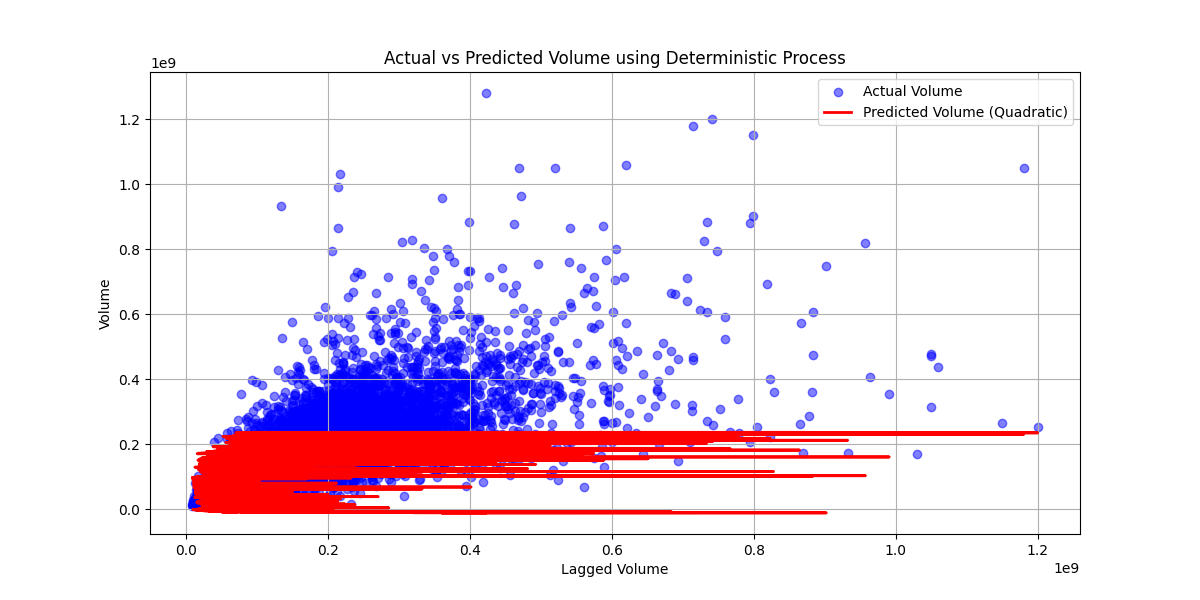

# Ridge Regression

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Load the stock price data
file_path = 'Updated_Data.csv'
data = pd.read_csv(file_path)

# Features (X) and target (y)
X = data.drop(columns=['Close'])
y = data['Close']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Refine the model using Ridge Regression (L2 regularization)
ridge_model = Ridge(alpha=1.0)

# Train the Ridge model
ridge_model.fit(X_train_scaled, y_train)

# Make predictions using the refined Ridge model
ridge_y_pred = ridge_model.predict(X_test_scaled)

# Calculate performance metrics for Ridge model
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, ridge_y_pred)

# Print the refined metrics
print(f"Ridge Regression RMSE: {ridge_rmse}")
print(f"Ridge Regression R²: {ridge_r2}")

# Plot actual vs predicted values using Ridge model
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(ridge_y_pred, label='Predicted Values (Ridge)', color='orange')
plt.title('Actual vs Predicted Stock Prices (Ridge Regression)')
plt.xlabel('Data Points')
plt.ylabel('Stock Price (Close)')
plt.legend()
plt.show()


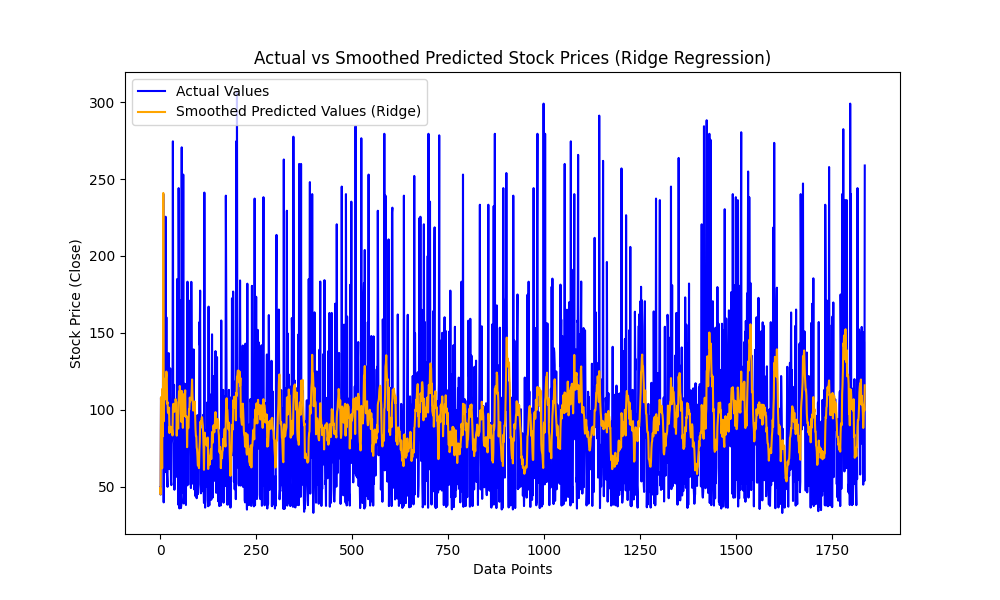